# Profiling skforecast

This document shows the profiling of the main classes, methods and functions available in skforecast. Understanding the are the bottle necks will help to:

+ Use it more efficiently
+ Improve the code for future releases


## Libraries

In [47]:
# Libraries
# ==============================================================================
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from lightgbm import LGBMRegressor

%load_ext pyinstrument

The pyinstrument extension is already loaded. To reload it, use:
  %reload_ext pyinstrument


## Data

A time series of length 1000 is created with random values.

In [48]:
# Data
# ==============================================================================
n = 1_000
data = pd.Series(data = np.random.normal(size=n))

## Dummy regressor

To isolate the training process of the regressor from the other parts of code, a dummy regressor class is created. This dummy regressor has a method fit that does nothing, and a predict method that returns a constant value.

In [49]:
class DummyRegressor(LinearRegression):
    '''
    Dummy regressor with dummy fit and predict methods.
    '''
    
    def fit(self, X, y):
        pass

    def predict(self, y):
        predictions = np.ones(shape = len(y))
        return predictions
        

## Profiling fit

In [50]:
%%pyinstrument

forecaster = ForecasterAutoreg(
                    regressor = DummyRegressor(),
                    lags      = 24
             )
forecaster.fit(y=data)

_     ._   __/__   _ _  _  _ _/_   Recorded: 18:18:35  Samples:  9
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.010     CPU time: 0.012
/   _/                      v4.3.0

Program: /home/ubuntu/anaconda3/envs/skforecast/lib/python3.8/site-packages/ipykernel_launcher.py --ip=127.0.0.1 --stdin=9008 --control=9006 --hb=9005 --Session.signature_scheme="hmac-sha256" --Session.key=b"388a5e00-9e44-4112-b6d2-a46f5cd02de3" --shell=9007 --transport="tcp" --iopub=9009 --f=/home/ubuntu/.local/share/jupyter/runtime/kernel-v2-1523iwvRASRRukbf.json

0.009 <module>  ../../../../../../tmp/ipykernel_12532/3559980462.py:2
`- 0.009 fit  skforecast/ForecasterAutoreg/ForecasterAutoreg.py:384
      [16 frames hidden]  skforecast, <built-in>, numpy, <__arr...
         0.008 _create_lags  skforecast/ForecasterAutoreg/ForecasterAutoreg.py:245
         |- 0.005 [self]  
         |- 0.002 arange  <built-in>:0

Almost the whole time spent by `fit` is required by the method `create_train_X_y`.

In [51]:
%%pyinstrument

forecaster = ForecasterAutoreg(
                    regressor = HistGradientBoostingRegressor(max_iter=10, random_state=123),
                    lags      = 24
             )

forecaster.fit(y=data)

_     ._   __/__   _ _  _  _ _/_   Recorded: 18:18:36  Samples:  86
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.170     CPU time: 0.767
/   _/                      v4.3.0

Program: /home/ubuntu/anaconda3/envs/skforecast/lib/python3.8/site-packages/ipykernel_launcher.py --ip=127.0.0.1 --stdin=9008 --control=9006 --hb=9005 --Session.signature_scheme="hmac-sha256" --Session.key=b"388a5e00-9e44-4112-b6d2-a46f5cd02de3" --shell=9007 --transport="tcp" --iopub=9009 --f=/home/ubuntu/.local/share/jupyter/runtime/kernel-v2-1523iwvRASRRukbf.json

0.170 <module>  ../../../../../../tmp/ipykernel_12532/1755484563.py:2
`- 0.170 fit  skforecast/ForecasterAutoreg/ForecasterAutoreg.py:384
      [127 frames hidden]  skforecast, sklearn, <built-in>, nump...
         0.061 ndarray.partition  <built-in>:0

When training a forecaster with a real machine learning regressor, the time spent by `create_train_X_y` is negligible compared to the time need by the `fit` method of the regressor. Therefore, improving the speed of `create_train_X_y` will not have much impact. 

## Profiling create_train_X_y

To understand how the method `create_train_X_y` is influenced by the length of the series and number of lags. 

In [52]:
# Profiling `create_train_X_y` for different length of series and number of lags
# ======================================================================================
series_length = np.geomspace(1000, 1000000, num=3, dtype=int)
n_lags = [5, 10, 50, 100, 200]
results = {}

for lags in n_lags:
    execution_time = []
    forecaster = ForecasterAutoreg(
                    regressor = DummyRegressor(),
                    lags      = lags
                 )

    for n in series_length:
        y = pd.Series(data = np.random.normal(size=n))
        tic = time.perf_counter()
        _ = forecaster.create_train_X_y(y=y)
        toc = time.perf_counter()
        execution_time.append(toc-tic)

    results[lags] = execution_time

results = pd.DataFrame(
            data =  results,
            index = series_length
        )

results

,5,10,50,100,200
1000,0.007323,0.006405,0.006742,0.007569,0.009316
31622,0.179664,0.186768,0.192331,0.202898,0.241928
1000000,5.620570,5.736563,6.077742,6.637242,8.093367


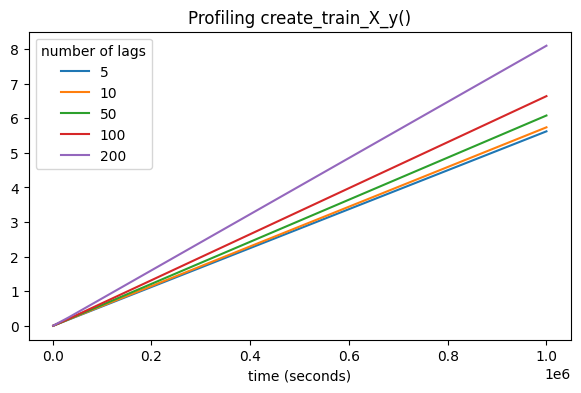

In [53]:
fig, ax = plt.subplots(figsize=(7, 4))
results.plot(ax=ax)
ax.set_xlabel('length of series')
ax.set_xlabel('time (seconds)')
ax.set_title('Profiling create_train_X_y()')
ax.legend(title="number of lags")

## Profiling predict

In [54]:
forecaster = ForecasterAutoreg(
                    regressor = DummyRegressor(),
                    lags      = 24
             )
forecaster.fit(y=data)

In [55]:
%%pyinstrument

_ = forecaster.predict(steps=1000)

_     ._   __/__   _ _  _  _ _/_   Recorded: 18:19:10  Samples:  49
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.053     CPU time: 0.076
/   _/                      v4.3.0

Program: /home/ubuntu/anaconda3/envs/skforecast/lib/python3.8/site-packages/ipykernel_launcher.py --ip=127.0.0.1 --stdin=9008 --control=9006 --hb=9005 --Session.signature_scheme="hmac-sha256" --Session.key=b"388a5e00-9e44-4112-b6d2-a46f5cd02de3" --shell=9007 --transport="tcp" --iopub=9009 --f=/home/ubuntu/.local/share/jupyter/runtime/kernel-v2-1523iwvRASRRukbf.json

0.053 <module>  ../../../../../../tmp/ipykernel_12532/3639615597.py:2
|- 0.048 predict  skforecast/ForecasterAutoreg/ForecasterAutoreg.py:515
|     [29 frames hidden]  skforecast, <__array_function__ inter...
|        0.048 _recursive_predict  skforecast/ForecasterAutoreg/ForecasterAutoreg.py:465
|        |  0.015 implement_array_function  <built-in>:0
|        |- 0.007 predict  ../../../../../../tmp/ipykernel_12532/2995770353.py:9
|        |  |- 0.004 ones  numpy/core/numeric.py:149
|        |  |     [6 frames hidden]  numpy, <__array_function__ internals>...
|        |  `- 0.003 [self]  
`- 0.004 [self]

In [56]:
forecaster = ForecasterAutoreg(
                    regressor = HistGradientBoostingRegressor(max_iter=10, random_state=123),
                    lags      = 24
             )

forecaster.fit(y=data)

In [57]:
%%pyinstrument

_ = forecaster.predict(steps=1000)

_     ._   __/__   _ _  _  _ _/_   Recorded: 18:19:11  Samples:  544
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.620     CPU time: 4.825
/   _/                      v4.3.0

Program: /home/ubuntu/anaconda3/envs/skforecast/lib/python3.8/site-packages/ipykernel_launcher.py --ip=127.0.0.1 --stdin=9008 --control=9006 --hb=9005 --Session.signature_scheme="hmac-sha256" --Session.key=b"388a5e00-9e44-4112-b6d2-a46f5cd02de3" --shell=9007 --transport="tcp" --iopub=9009 --f=/home/ubuntu/.local/share/jupyter/runtime/kernel-v2-1523iwvRASRRukbf.json

0.620 <module>  ../../../../../../tmp/ipykernel_12532/3639615597.py:2
`- 0.620 predict  skforecast/ForecasterAutoreg/ForecasterAutoreg.py:515
      [182 frames hidden]  skforecast, sklearn, <built-in>, <__a...
         0.202 _predict_from_raw_data  <built-in>:0

Inside the `predict` method, the `append` action is the most expensive but, similar to what happen with `fit`, it is negligible compared to the time need by the `predict` method of the regressor.

In [63]:
%%html
<style>
.jupyter-wrapper .jp-CodeCell .jp-Cell-inputWrapper .jp-InputPrompt {display: none;}
</style>